In [133]:
import pandas as pd
import numpy as np
import os
import sys
import timeit
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


In [134]:
from upsetplot import from_contents

In [135]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
iso_tpm_1 = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/bambu/all_trans_norm.counts.fn',sep='\t')
# iso_tpm_2 = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/165samples_tpm_mstrg.csv',sep='\t')

In [223]:
# iso_tpm = iso_tpm_1.merge(iso_tpm_2).set_index('transcript_id')
group = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/bambu/288_group.csv',sep='\t')
group['tissue'] = group['Sample ID'].str[:3]

In [7]:
tpm_dict={}
for key,value in iso_tpm_1.T.reset_index().rename(columns={'index':'name'}).merge(group).groupby('tissue'):
    tpm_dict[key] = value.drop(['Sample ID','tissue'],axis=1).set_index('name')

In [116]:
convert = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/bambu/CPM_transcript.txt',sep='\t')
convert = convert.loc[convert.GENEID.str.startswith('ENSG')][['TXNAME','GENEID']]

In [10]:
normal_primary_data = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/bambu/288_all_tissue_normal_primary.csv',sep='\t',index_col=0)
normal_primary_data = normal_primary_data.loc[normal_primary_data.index.isin(convert.TXNAME)]

In [11]:
data = iso_tpm_1.T.reset_index().rename(columns={'index':'name'}).merge(group[['name','Type','Sample ID','tissue']])

In [224]:
tissue = group.tissue.drop_duplicates()

In [225]:
suppa_files = os.listdir('/data1/HOMO_PANGENOME/DYY/data/bambu/288_normal_trans_suppa_types/')

for tis in tissue:
    ts_df = pd.read_csv(f'/data1/HOMO_PANGENOME/DYY/data/bambu/288_tumor_specific_trans/{tis}',sep='\t',header=None)
    
    tis_df = pd.DataFrame(index=convert.TXNAME,columns=[x[:2] for x in suppa_files])
    for s in suppa_files:
        suppa_df = pd.read_csv(f'/data1/HOMO_PANGENOME/DYY/data/bambu/288_normal_trans_suppa_types/{s}',index_col=0)
        su = s[:2]
        suppa_tis = suppa_df.loc[suppa_df[tis]==1]
        tis_df.loc[tis_df.index.isin(suppa_tis.index.tolist()),su] = 1
    tis_df.to_csv('/data1/HOMO_PANGENOME/DYY/data/bambu/288_novel_trans/'+tis,sep='\t')

In [139]:
trans_path = '/data1/HOMO_PANGENOME/DYY/data/bambu/288_novel_trans/'
# trans_path = '/data1/HOMO_PANGENOME/DYY/data/8.8tumor_specific_trans/'
# trans_path = '/data1/HOMO_PANGENOME/DYY/data/11.28normal_trans_suppa_types/'
trans_files = os.listdir(trans_path)
# trans_files = [x for x in trans_files if x[-3:]=='csv']

In [140]:
plot_dict = {}
all_dict = {}
ts_novel_dict={}
for f in trans_files:
    tissue_dict={}
    dat = pd.read_csv(trans_path+f, index_col=0, sep='\t')
    # break
    dat = dat.fillna(0)
    ts_dat = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/bambu/288_tumor_specific_trans/'+f,sep='\t',header=None)
    for t in dat.columns.tolist():
        tissue_dict[t] = dat.loc[dat[t]!=0].index.tolist()
    tissue_df = from_contents(tissue_dict).reset_index().set_index('id')
    for i in dat.columns.tolist():
        tissue_df.loc[tissue_df[i],i] = i
    tissue_df['merged'] = tissue_df.apply(lambda row: ''.join(str(cell) for cell in row if cell != False), axis=1)
    ts_df = dat.loc[dat.index.isin(ts_dat[0])]

    ts_df['merged'] =  ts_df.apply(lambda row: ''.join(row.index[row == 1]), axis=1)
    all_dict[f[:3]] = tissue_df
    plot_dict[f[:3]] = tissue_df[tissue_df['merged'].str.len() > 2]
    ts_novel_dict[f[:3]] = ts_df

In [141]:
ts_dict={}
for f in trans_files:
    ts_dat = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/bambu/288_tumor_specific_trans/'+f,sep='\t',header=None)
    ts_normal = normal_primary_data.loc[normal_primary_data[f[:3]]==1].index.tolist()
    nov = len(ts_dat)
    ts_dat = ts_dat.loc[~ts_dat[0].isin(ts_normal)]
    ts_dict[f] = ts_dat
    droped=len(ts_dat)
    if nov!=droped:
        print(f'droped {nov-droped} trans !')

droped 728 trans !
droped 452 trans !
droped 371 trans !
droped 847 trans !
droped 500 trans !
droped 216 trans !
droped 297 trans !
droped 80 trans !
droped 551 trans !
droped 334 trans !


In [35]:
gene_name = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/ensg_gene_name.csv',sep='\t').drop_duplicates().rename(columns={'1':'GENEID','7':'gene_name'})

In [50]:
test = pd.concat(plot_dict).reset_index()

In [54]:
test = test.loc[(test.merged=='ALAF') & (test.id.str.startswith('ENS'))]

In [142]:
ts_suppa_count = pd.DataFrame()
for k,v in ts_novel_dict.items():
    v = v.drop('merged',axis=1)
    try:
        ts_suppa_count = pd.concat([ts_suppa_count,pd.DataFrame(v.loc[v.sum(axis=1)==1].sum()).rename(columns={0:k})],axis=1)
    except:
        ts_suppa_count = pd.DataFrame(v.loc[v.sum(axis=1)==1].sum()).rename(columns={0:k}).copy()
    # break

In [130]:
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

In [16]:
convert = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/mstrg_ensg_transcript.csv', sep='\t')

In [143]:
p_dict = {}
ratio_dict = {}
for f in trans_files:
    tissue = f[:3]
    p_df = pd.DataFrame()
    # multi = all_dict[tissue][all_dict[tissue].merged.str.len() >= 4]
    all_data = all_dict[tissue]
    ts_counts = len(all_dict[tissue])
    A5 = len(all_data[all_data.A5=='A5'])
    A3 = len(all_data[all_data.A3=='A3'])
    AF = len(all_data[all_data.AF=='AF'])
    AL = len(all_data[all_data.AL=='AL'])
    SE = len(all_data[all_data.SE=='SE'])
    RI = len(all_data[all_data.RI=='RI'])
    MX = len(all_data[all_data.MX=='MX'])
    dupl = all_dict[tissue][all_dict[tissue].merged.str.len() == 4]
    dupl_list = dupl.merged.drop_duplicates().tolist()
    multi = all_dict[tissue][all_dict[tissue].merged.str.len() >= 4]
    multi_list = multi.merged.drop_duplicates().tolist()
    # mono = all_dict[tissue][all_dict[tissue].merged.str.len() == 2]
    mono_df = pd.DataFrame(index=all_dict[tissue].columns.tolist()[:-1])
    mono_df.loc[:,'counts'] = mono_df.index.map(all_dict[tissue].merged.value_counts())
    ratio_df = pd.DataFrame()
    for d in dupl_list:
        # t1 = mono_df.loc[d[:2]].counts/ts_counts
        # t2 = mono_df.loc[d[2:]].counts/ts_counts
        # t1 = mono_df.loc[d[:2]].counts
        # t2 = mono_df.loc[d[2:]].counts
        # tb = len(all_dict[tissue][all_dict[tissue].merged.str.contains(d[2:])
        # ta = len(all_dict[tissue][all_dict[tissue].merged.str.contains(d[:2])])
        both = len(all_data[(all_data[f'{d[:2]}']==d[:2]) & (all_data[f'{d[-2:]}']==d[-2:])])
        t1 = len(all_data[(all_data[f'{d[:2]}']==d[:2]) & (all_data[f'{d[-2:]}']!=d[-2:])])
        t2 = len(all_data[(all_data[f'{d[:2]}']!=d[:2]) & (all_data[f'{d[-2:]}']==d[-2:])])
        non = len(all_data[(all_data[f'{d[:2]}']!=d[:2]) & (all_data[f'{d[-2:]}']!=d[-2:])])
        # t = len(dupl.loc[dupl.merged==d])
        # p = chi2_contingency([[t, ts_counts-t],[t1*t2*2*ts_counts, (ts_counts-t1*t2*2/ts_counts)]])[1]
        array = np.array([[both, t1],[t2, non]])
        if (array <= 5 ).any():
            p = fisher_exact(array)[1]
        else:
            p = chi2_contingency(array)[1]
        p_df.loc[d,'p'] = p
    for i in multi_list:
        m = len(all_data[all_data.merged==i])
        ratio_df.loc[i,'count'] = m
        ratio_df.loc[i,'ratio'] = m/len(all_data)
    p_dict[tissue] = p_df
    ratio_dict[tissue] = ratio_df
    # break
    
    

In [239]:
gene_name.loc[gene_name.gene_name=='CXCR4']

,GENEID,gene_name
33233,ENSG00000121966.8,CXCR4


In [249]:
convert_df = convert.merge(gene_name)

In [247]:
test = merged_df[merged_df=='A5AL']

In [253]:
test[test.count(axis=1)>0].tail()

first,LIV,CER,STO,LUN,BRE,BLA,END,REC,KID,COL,different_values_columns
id,,,,,,,,,,,
ENST00000448803.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN
ENST00000449879.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN
ENST00000568929.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN
ENST00000674662.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN
ENST00000675329.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN


In [254]:
convert_df.loc[convert_df.TXNAME.isin(test[test.count(axis=1)>0].tail(10).index.tolist())]

,TXNAME,GENEID,gene_name
6595,ENST00000448803.6,ENSG00000176371.14,ZSCAN2
8227,ENST00000568929.1,ENSG00000167523.15,SPATA33
24611,ENST00000421806.4,ENSG00000196233.14,LCOR
51561,BambuTx12722,ENSG00000090565.17,RAB11FIP3
51568,ENST00000449879.6,ENSG00000090565.17,RAB11FIP3
89098,ENST00000654888.1,ENSG00000245937.10,SLC12A2-DT
89117,ENST00000687795.1,ENSG00000245937.10,SLC12A2-DT
99731,ENST00000637282.1,ENSG00000187391.22,MAGI2
119334,ENST00000674662.1,ENSG00000203485.14,INF2
119350,ENST00000675329.1,ENSG00000203485.14,INF2


In [255]:
normal_primary_data.reset_index().merge(convert_df).set_index('gene_name').loc['RAB11FIP3']

,TXNAME,BLA,BRE,CER,COL,END,STO,LIV,LUN,REC,KID,GENEID
gene_name,,,,,,,,,,,,
RAB11FIP3,BambuTx12720,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,ENSG00000090565.17
RAB11FIP3,BambuTx12723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,ENSG00000090565.17
RAB11FIP3,ENST00000262305.9,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN,ENSG00000090565.17


In [259]:
test[test.count(axis=1)>0].tail(10)

first,LIV,CER,STO,LUN,BRE,BLA,END,REC,KID,COL,different_values_columns
id,,,,,,,,,,,
ENST00000637282.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN,NaN
ENST00000654888.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN,NaN
ENST00000687795.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN,NaN
BambuTx12722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN
ENST00000421806.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN
ENST00000448803.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN
ENST00000449879.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN
ENST00000568929.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN
ENST00000674662.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A5AL,NaN,NaN


In [144]:
import scipy.stats as stats
import itertools

In [86]:
alldupl_list = p_dupl.index.tolist()

NameError: name 'p_dupl' is not defined

In [145]:
ts_p = {}
for f in trans_files:
    tissue = f[:3]
    ts_data = ts_novel_dict[tissue]
    p_df=pd.DataFrame()
    # ratio_df=pd.DataFrame()
    for d in dupl_list:
        # t1 = mono_df.loc[d[:2]].counts/ts_counts
        # t2 = mono_df.loc[d[2:]].counts/ts_counts
        # t1 = mono_df.loc[d[:2]].counts
        # t2 = mono_df.loc[d[2:]].counts
        # tb = len(all_dict[tissue][all_dict[tissue].merged.str.contains(d[2:])
        # ta = len(all_dict[tissue][all_dict[tissue].merged.str.contains(d[:2])])
        both = len(ts_data[(ts_data[f'{d[:2]}']==1) & (ts_data[f'{d[-2:]}']==1)])
        t1 = len(ts_data[(ts_data[f'{d[:2]}']==1) & (ts_data[f'{d[-2:]}']!=1)])
        t2 = len(ts_data[(ts_data[f'{d[:2]}']!=1) & (ts_data[f'{d[-2:]}']==1)])
        non = len(ts_data[(ts_data[f'{d[:2]}']!=1) & (ts_data[f'{d[-2:]}']!=1)])
        # t = len(dupl.loc[dupl.merged==d])
        # p = chi2_contingency([[t, ts_counts-t],[t1*t2*2*ts_counts, (ts_counts-t1*t2*2/ts_counts)]])[1]
        array = np.array([[both, t1],[t2, non]])
        if (array <= 5 ).any():
            p = fisher_exact(array)[1]
        else:
            p = chi2_contingency(array)[1]
        p_df.loc[d,'p'] = p

        # ratio_df.loc[i,'count'] = m
        # ratio_df.loc[i,'ratio'] = m/len(ts_data)
    ts_p[tissue] = p_df

In [146]:
ts_novel_p_df = pd.concat(ts_p,axis=1)

In [147]:
from statsmodels.stats.multitest import fdrcorrection

In [23]:
mainly_df = pd.concat(my_dict, axis=1)

NameError: name 'my_dict' is not defined

In [153]:
mainly_df

LIV                                                            \
            A3_p      RI_p      MX_p      AL_p          AF_p          SE_p   
A5  2.627239e-04  0.133486  0.010683  0.608279  1.334860e-01  2.019214e-05   
A3  1.000000e+00  0.037113  0.037113  0.129778  1.466351e-07  7.260571e-10   
RI  4.639080e-02  1.000000  0.012464  0.012464  1.246403e-02  1.297781e-01   
MX  3.092720e-02  0.007478  1.000000  0.007478  7.478420e-03  7.478420e-03   
AL  1.557337e-01  0.018696  0.018696  1.000000  4.639080e-02  4.639080e-02   
AF  2.932703e-07  0.009348  0.009348  0.037113  1.000000e+00  5.837913e-05   
SE  7.260571e-10  0.129778  0.009348  0.037113  3.891942e-05  1.000000e+00   

                       LUN                      ...           REC  \
        A5_p          A3_p      RI_p      MX_p  ...          AF_p   
A5  1.000000  1.477545e-09  0.242732  0.242732  ...  5.709404e-01   
A3  0.000204  1.000000e+00  0.042601  0.006831  ...  1.056313e-07   
RI  0.129778  6.390131e-02  1.000000  0.002009  ...  3.045023e-02   
MX  0.007478  6.831416e-03  0.001339  1.000000  ...  3.122736e-03   
AL  0.709659  1.004583e-03  0.001005  0.001005  ...  1.802982e-01   
AF  0.129778  6.177148e-06  0.063901  0.011386  ...  1.000000e+00   
SE  0.000012  2.200986e-05  0.704376  0.000804  ...  5.813557e-03   

                                         COL                                \
            SE_p          A5_p          A3_p      RI_p      MX_p      AL_p   
A5  4.983049e-03  1.000000e+00  3.413080e-04  0.093504  0.019522  0.835779   
A3  4.729973e-09  4.729973e-09  1.000000e+00  0.158475  0.002268  0.013665   
RI  6.660971e-01  1.802982e-01  1.901704e-01  1.000000  0.022775  0.022775   
MX  2.030016e-02  3.122736e-03  3.024500e-03  0.013665  1.000000  0.003024   
AL  6.660971e-01  1.802982e-01  2.277515e-02  0.022775  0.009073  1.000000   
AF  5.813557e-03  6.660971e-01  5.275382e-08  0.013665  0.003024  0.158475   
SE  1.000000e+00  5.813557e-03  2.218752e-10  0.402885  0.109088  0.109088   

                                          
            AF_p          SE_p      A5_p  
A5  1.952156e-02  8.357789e-01  1.000000  
A3  2.637691e-08  2.218752e-10  0.000133  
RI  2.277515e-02  3.357374e-01  0.109088  
MX  3.024500e-03  7.272517e-02  0.013665  
AL  1.901704e-01  1.090878e-01  0.975075  
AF  1.000000e+00  1.990963e-04  0.013665  
SE  1.990963e-04  1.000000e+00  0.975075  

[7 rows x 70 columns]

In [137]:
test_mainly_df = mainly_df[mainly_df<0.05]

In [149]:
calcu = pd.DataFrame()
for key,value in my_dict.items():
    tmp = pd.DataFrame(value[value<0.05].count(axis=1)).rename(columns={0:key})
    try:
        calcu = pd.concat([calcu,tmp],axis=1)
    except:
        calcu = tmp.copy()

In [152]:
calcu.sum(axis=1).sort_values()

AL    32
A5    35
RI    36
AF    38
SE    39
A3    48
MX    54
dtype: int64

In [148]:
p_dupl = pd.concat(p_dict, axis=1)

In [182]:
p_dupl

,LIV,CER,STO,LUN,BRE,BLA,END,REC,KID,COL
,p,p,p,p,p,p,p,p,p,p
A5AL,3.938824e-297,2.869485e-302,3.980783e-297,1.066803e-293,3.127665e-285,6.325519e-279,1.728377e-305,5.389633e-297,6.484877e-288,1.924580e-296
A5SE,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A5AF,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A5MX,8.372607e-34,1.006780e-33,1.914515e-38,2.564555e-37,9.398043e-34,6.377481e-33,6.445299e-36,1.117057e-37,2.633143e-34,1.552223e-35
A5RI,1.848242e-77,4.073806e-71,6.969477e-84,4.101403e-78,2.255526e-81,4.254441e-81,4.802806e-73,1.087491e-78,1.133116e-76,9.423176e-81
A5A3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A3AF,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A3AL,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
A3SE,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [184]:
from statsmodels.stats.multitest import multipletests

In [212]:
def fdr_by_column(p_values):
    # 使用 Benjamini-Hochberg 方法进行 FDR 校正
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
    return pvals_corrected

# 应用 FDR 校正到每一列（按基因）
df_corrected = ts_novel_p_df.apply(fdr_by_column, axis=1)

# 将校正后的结果转换为 DataFrame
# df_corrected = pd.DataFrame(df_corrected, index=p_dupl.index)

In [213]:
df_split = pd.DataFrame(df_corrected).apply(lambda x: pd.Series(x[0]), axis=1)

In [216]:
df_split.columns = ts_novel_p_df.columns

In [218]:
df_split.T.to_csv('/data1/HOMO_PANGENOME/DYY/data/bambu/s6.csv',sep='\t')

In [150]:
dupl_ratio = pd.concat(ratio_dict,axis=1)

In [151]:
dupl_ratio.head()

LIV               CER               STO               LUN  \
         count     ratio   count     ratio   count     ratio   count   
A5AL     699.0  0.007501   706.0  0.007543   736.0  0.007842   681.0   
A5SE    1737.0  0.018641  1765.0  0.018857  1860.0  0.019818  1747.0   
A5ALAF   129.0  0.001384   142.0  0.001517   142.0  0.001513   136.0   
A5RIAF    60.0  0.000644    76.0  0.000812    75.0  0.000799    80.0   
A5A3AF   161.0  0.001728   194.0  0.002073   187.0  0.001992   181.0   

                     BRE               BLA               END            \
           ratio   count     ratio   count     ratio   count     ratio   
A5AL    0.007251   701.0  0.007457   670.0  0.007153   684.0  0.007296   
A5SE    0.018602  1845.0  0.019627  1703.0  0.018182  1814.0  0.019350   
A5ALAF  0.001448   132.0  0.001404   126.0  0.001345   139.0  0.001483   
A5RIAF  0.000852    68.0  0.000723    65.0  0.000694    76.0  0.000811   
A5A3AF  0.001927   181.0  0.001925   179.0  0.001911   194.0  0.002069   

           REC               KID               COL            
         count     ratio   count     ratio   count     ratio  
A5AL     669.0  0.007184   717.0  0.007673   689.0  0.007349  
A5SE    1742.0  0.018705  1798.0  0.019242  1764.0  0.018816  
A5ALAF   117.0  0.001256   135.0  0.001445   136.0  0.001451  
A5RIAF    71.0  0.000762    79.0  0.000845    77.0  0.000821  
A5A3AF   170.0  0.001825   183.0  0.001958   173.0  0.001845

In [152]:
t_p_dupl = p_dupl.T
t_p_dupl.index = t_p_dupl.index.map('-'.join)

In [100]:
# t_p_dupl.reset_index().set_index('index').to_csv('/data1/HOMO_PANGENOME/DYY/data/new_dupl_alternative_splicing_sig.csv',sep='\t')

In [153]:
t_p_dupl[t_p_dupl<0.05]

,A5AL,A5SE,A5AF,A5MX,A5RI,A5A3,A3AF,A3AL,A3SE,A3RI,...,RIAF,RISE,RIAL,RIMX,MXAF,MXAL,MXSE,ALAF,ALSE,AFSE
LIV-p,3.938824e-297,0.0,0.0,8.372607e-34,1.848242e-77,0.0,0.0,0.0,0.0,3.069923e-106,...,2.173984e-289,2.392972e-236,1.052710e-108,6.896027e-11,2.160002e-33,6.639477e-10,8.007520e-27,6.933395e-253,0.0,0.0
CER-p,2.869485e-302,0.0,0.0,1.006780e-33,4.073806e-71,0.0,0.0,0.0,0.0,1.411416e-97,...,1.581318e-273,9.971758e-243,4.396155e-103,4.921181e-11,8.188094e-33,7.266296e-11,5.597684e-27,1.956939e-247,0.0,0.0
STO-p,3.980783e-297,0.0,0.0,1.914515e-38,6.969477e-84,0.0,0.0,0.0,0.0,2.298791e-95,...,1.845808e-275,6.675295e-239,4.956607e-101,1.877304e-10,1.960074e-45,1.017395e-09,2.548801e-31,1.428385e-255,0.0,0.0
LUN-p,1.066803e-293,0.0,0.0,2.564555e-37,4.101403e-78,0.0,0.0,0.0,0.0,2.180388e-96,...,3.826496e-266,6.699394e-252,3.495621e-101,1.411678e-10,1.784201e-40,2.695516e-10,8.836568e-30,9.934125e-254,0.0,0.0
BRE-p,3.127665e-285,0.0,0.0,9.398043e-34,2.255526e-81,0.0,0.0,0.0,0.0,7.956727e-108,...,2.502299e-290,7.681227e-251,4.898899e-113,9.895808e-10,8.404327e-34,9.607884e-09,4.702822e-25,6.882845e-245,0.0,0.0
BLA-p,6.325519e-279,0.0,0.0,6.377481e-33,4.254441e-81,0.0,0.0,0.0,0.0,1.141239e-110,...,3.233796e-286,3.638726e-255,1.063041e-107,8.221086e-11,1.968043e-35,1.421570e-08,7.257593e-27,3.077229e-251,0.0,0.0
END-p,1.728377e-305,0.0,0.0,6.445299e-36,4.802806e-73,0.0,0.0,0.0,0.0,1.074599e-92,...,1.716905e-264,3.642501e-244,1.966001e-100,7.357110e-09,5.428238e-40,4.025487e-10,5.156351e-31,9.207760e-253,0.0,0.0
REC-p,5.389633e-297,0.0,0.0,1.117057e-37,1.087491e-78,0.0,0.0,0.0,0.0,6.098056e-93,...,5.733391e-274,1.722852e-248,5.415009e-101,3.561347e-10,1.677809e-40,3.422449e-10,1.194140e-28,6.308190e-252,0.0,0.0
KID-p,6.484877e-288,0.0,0.0,2.633143e-34,1.133116e-76,0.0,0.0,0.0,0.0,5.970250e-102,...,3.069581e-274,3.191034e-247,1.811008e-102,3.544817e-10,3.337202e-39,5.166186e-10,8.181554e-29,2.681803e-249,0.0,0.0
COL-p,1.924580e-296,0.0,0.0,1.552223e-35,9.423176e-81,0.0,0.0,0.0,0.0,4.015186e-95,...,2.433519e-272,1.400504e-250,5.299043e-100,4.121517e-10,6.434346e-42,9.299711e-09,7.177456e-30,1.333557e-251,0.0,0.0


In [155]:
ratio_df = pd.DataFrame(index = [x[:3] for x in trans_files])
for f in trans_files:
    tissue = f[:3]
    ratio = len(plot_dict[tissue]) / len(all_dict[tissue])
    mono_ratio = len(all_dict[tissue][all_dict[tissue].merged.str.len() == 2]) / len(all_dict[tissue])
    ratio_df.loc[tissue,'multi_ratio'] = ratio
    ratio_df.loc[tissue,'mono_ratio'] = mono_ratio

In [156]:
ratio_df.std()

multi_ratio    0.002391
mono_ratio     0.002391
dtype: float64

In [157]:
ratio_df.sort_values('mono_ratio')

,multi_ratio,mono_ratio
STO,0.181283,0.818717
CER,0.178869,0.821131
END,0.178434,0.821566
COL,0.176996,0.823004
KID,0.176600,0.823400
LUN,0.176581,0.823419
BRE,0.175422,0.824578
LIV,0.174925,0.825075
REC,0.173716,0.826284
BLA,0.173710,0.826290


In [158]:
ratio_df.sort_values('multi_ratio').to_csv('/data1/HOMO_PANGENOME/DYY/data/bambu/dupl_as_mono_as.csv',sep='\t')

In [24]:
normal_primary_data[normal_primary_data.COL==-1]#.loc[plot_dict['COL'].index.tolist()]

,LIV,LUN,BLA,KID,END,CER,BRE,STO,REC,COL
MSTRG.100022.4,NaN,NaN,NaN,NaN,-1.0,NaN,-1.0,-1.0,-1.0,-1.0
MSTRG.100162.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
MSTRG.100162.5,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,-1.0
MSTRG.100184.2,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,-1.0
MSTRG.100219.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...
MSTRG.99175.1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,-1.0
MSTRG.99298.4,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
MSTRG.99385.1,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
MSTRG.99909.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [159]:
merged_df = pd.concat(plot_dict,axis=1).loc[:, (slice(None), 'merged')]
merged_df.head()

,LIV,CER,STO,LUN,BRE,BLA,END,REC,KID,COL
,merged,merged,merged,merged,merged,merged,merged,merged,merged,merged
id,,,,,,,,,,
BambuTx73,A5AL,A5ALAF,A5AL,A5AL,A5AL,A5AL,A5ALAF,A5AL,A5AL,A5AL
BambuTx75,A5SE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BambuTx114,A5ALAF,A5ALAF,A5ALAF,A5ALAF,A5ALAF,A5ALAF,A5ALAF,A5ALAF,A5ALAF,A5ALAF
BambuTx115,A5AL,A5AL,A5AL,A5AL,A5AL,A5AL,A5AL,A5AL,A5AL,A5AL
BambuTx119,A5RIAF,A5RIAF,A5RIAF,A5RIAF,A5RIAF,A5RIAF,A5RIAF,A5RIAF,A5RIAF,A5RIAF


In [160]:
merged_df['different_values_columns'] = merged_df.apply(lambda x: [x[col] for col in x.index if pd.notna(x[col])], axis=1)
merged_df['different_values_columns'] = merged_df['different_values_columns'].apply(lambda x: len(set(x))>1)

In [161]:
merged_df[merged_df.different_values_columns]

,LIV,CER,STO,LUN,BRE,BLA,END,REC,KID,COL,different_values_columns
,merged,merged,merged,merged,merged,merged,merged,merged,merged,merged,
id,,,,,,,,,,,
BambuTx73,A5AL,A5ALAF,A5AL,A5AL,A5AL,A5AL,A5ALAF,A5AL,A5AL,A5AL,True
BambuTx124,A5A3AF,A5AF,A5A3AF,A5A3AF,A5A3AF,A5A3AF,A5A3AF,A5A3AF,A5A3AF,A5A3AF,True
BambuTx242,A5AL,A5AL,A5AL,A5AL,A5ALSE,A5ALSE,A5ALSE,A5ALSE,A5AL,A5ALSE,True
BambuTx329,A5SE,NaN,A5AFSE,A5AFSE,A5SE,A5AFSE,A5SE,A5AFSE,A5AFSE,A5AFSE,True
BambuTx350,A5A3AF,A5AF,A5AF,A5AF,A5A3,A5A3AF,A5AF,A5AF,A5A3AF,A5AF,True
...,...,...,...,...,...,...,...,...,...,...,...
ENST00000667196.1,NaN,NaN,NaN,NaN,NaN,NaN,ALAF,ALAF,NaN,A5AL,True
ENST00000668414.1,NaN,NaN,NaN,NaN,NaN,NaN,ALAF,ALAF,NaN,A5AL,True


In [183]:
merged_df.loc[merged_df[merged_df.isin(['A5AF','A3SE','A3AF','AFSE','A5SE','A5A3'])].count(axis=1)>2].reset_index().merge(convert, left_on='id', right_on='transcript').merge(gene_name, left_on='ensg',right_on='1').drop(['mstrg','transcript','1'], axis=1)

,"(id, )","(LIV, merged)","(LUN, merged)","(BLA, merged)","(KID, merged)","(END, merged)","(CER, merged)","(BRE, merged)","(STO, merged)","(REC, merged)","(COL, merged)","(different_values_columns, )",ensg,7
0,MSTRG.12617.8,A5A3,NaN,A5A3,NaN,A5A3,NaN,NaN,NaN,NaN,NaN,False,ENSG00000143303.12,METTL25B
1,MSTRG.24104.6,A3AF,NaN,A3AF,NaN,NaN,NaN,NaN,NaN,NaN,A3AF,False,ENSG00000162927.14,PUS10
2,MSTRG.44875.8,A3AF,A3AF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A3AF,False,ENSG00000091527.17,CDV3
3,MSTRG.66979.7,A3AF,NaN,NaN,NaN,NaN,NaN,A3AF,A3AF,NaN,NaN,False,ENSG00000152422.16,XRCC4
4,MSTRG.42763.8,AFSE,NaN,NaN,NaN,NaN,NaN,NaN,AFSE,NaN,AFSE,False,ENSG00000064225.13,ST3GAL6
5,MSTRG.92232.3,NaN,NaN,A3AF,NaN,NaN,NaN,A3AF,NaN,NaN,A3AF,False,ENSG00000006704.11,GTF2IRD1
6,MSTRG.76216.14,NaN,NaN,NaN,A3AF,NaN,NaN,A3AF,A3AF,NaN,NaN,False,ENSG00000111913.20,RIPOR2


In [160]:
com_list = convert.loc[convert.transcript.isin(merged_df.loc[merged_df[merged_df.isin(['A5AF','A3SE','A3AF','AFSE','A5SE','A5A3'])].count(axis=1)>2].index)].ensg.tolist()

In [166]:
gene_name = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/ensg_gene_name.csv',sep='\t').drop_duplicates()

In [162]:
merged_df.columns.names=['first','second']

In [163]:
merged_df = merged_df.droplevel(level='second', axis=1)

In [164]:
novel_gene_df = convert.merge(merged_df.reset_index().rename(columns={'id':'transcript'}))[['mstrg']]

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

In [165]:
import seaborn as sns
group = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/group.csv',sep='\t')
pal = sns.color_palette(palette='tab10')
lut = dict(zip(list(group['Sample'].unique()), pal))
# Convert the palette to vectors that will be drawn on the side of the matrix
networks = plot_dict.keys()
colors = pd.Series(networks, index=plot_dict.keys()).map(lut)

In [166]:
replace_dict = pd.DataFrame(pd.concat(plot_dict.values())[['merged']].drop_duplicates()['merged'].tolist()).to_dict()[0]

In [167]:
swapped_dict = {v: k for k, v in replace_dict.items()}

In [168]:
len(swapped_dict)

78

In [169]:
plot_dict['BLA'].groupby('merged').count().

,A5,A3,RI,MX,AL,AF,SE
merged,,,,,,,
A3AF,1196,1196,1196,1196,1196,1196,1196
A3AFSE,145,145,145,145,145,145,145
A3AL,461,461,461,461,461,461,461
A3ALAF,52,52,52,52,52,52,52
A3ALAFSE,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...
RIALAFSE,1,1,1,1,1,1,1
RIALSE,9,9,9,9,9,9,9
RIMX,10,10,10,10,10,10,10


In [202]:
all_tissue_pattern_data = pd.DataFrame(pd.concat(plot_dict.values())[['merged']].drop_duplicates()['merged'].tolist()).rename(columns={0:'pattern'})
for k in plot_dict.keys():
    plot_data = plot_dict[k].groupby('merged').count().reset_index().rename(columns={'merged':'pattern','A3':k})[['pattern',k]]
    all_tissue_pattern_data = all_tissue_pattern_data.merge(plot_data,how='outer')
    # break

In [218]:
all_tissue_pattern_data.to_csv('/data1/HOMO_PANGENOME/DYY/data/subplot_bar_novel_trans_suppa_pattern.csv', sep='\t',index=False)

In [184]:
all_tissue_pattern_data=pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/subplot_bar_novel_trans_suppa_pattern.csv', sep='\t',index_col=0)

In [170]:
all_pattern_list = pd.concat(ts_novel_dict)['merged'].drop_duplicates().tolist()

In [172]:
all_pattern_list.remove('')

In [173]:
all_pattern_list = [x for x in all_pattern_list if len(x)>2]

In [174]:
pattern_data = pd.DataFrame(index=all_pattern_list)
for f in trans_files:
    tissue=f[:3]
    ts_tmp = ts_novel_dict[tissue]
    plot_df = ts_tmp[ts_tmp.merged.isin(all_pattern_list)]
    plot_df = plot_df.reset_index().groupby('merged').count()[['TXNAME']].rename(columns={'TXNAME':tissue})
    pattern_data = pd.concat([pattern_data,plot_df],axis=1)
    # break

In [175]:
import seaborn as sns

In [176]:
group = pd.read_csv('/data1/HOMO_PANGENOME/DYY/data/group.csv',sep='\t')
# group = pd.read_csv('/data1/DYY/data/group.csv', sep='\t')
pal = sns.color_palette(palette='tab10')
lut = dict(zip(list(group.Sample.unique()), pal))
networks = group.Sample.unique()
ten_colors = pd.Series(networks, index=group.Sample.unique()).map(lut)
del group

In [208]:
plot_data = pattern_data[pattern_data.sum(axis=1)>0]
plot_data = plot_data.sort_values('BLA',ascending=False)
plot_data = plot_data.sort_index(axis=1)

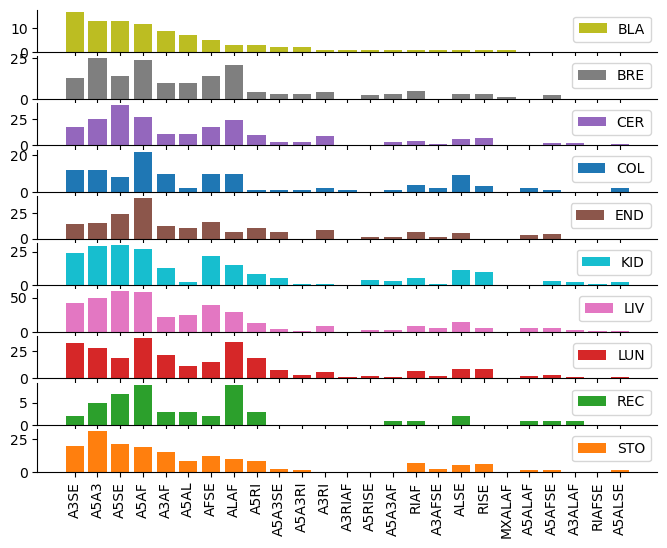

In [220]:
fig, axs = plt.subplots(10, 1, figsize=(8,6), sharex=True, gridspec_kw={"hspace": 0.1})
for i in range(10):
    tissue = plot_data.columns.tolist()[i]
    axs[i].bar(plot_data.head(25).index.tolist(),plot_data[tissue].head(25).tolist(), color = ten_colors[tissue], label=tissue)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].legend(loc='upper right')
    # axs[i].set_ylim(0,10)
plt.xticks(rotation=90)
# plt.show()
plt.savefig('/data1/HOMO_PANGENOME/DYY/data/bambu/plot/3d.pdf',bbox_inches='tight')

In [218]:
all_tissue_pattern_data = all_tissue_pattern_data[all_tissue_pattern_data.sum(axis=1)>0]
all_tissue_pattern_data = all_tissue_pattern_data.sort_values('BLA',ascending=False)
all_tissue_pattern_data = all_tissue_pattern_data.sort_index(axis=1)

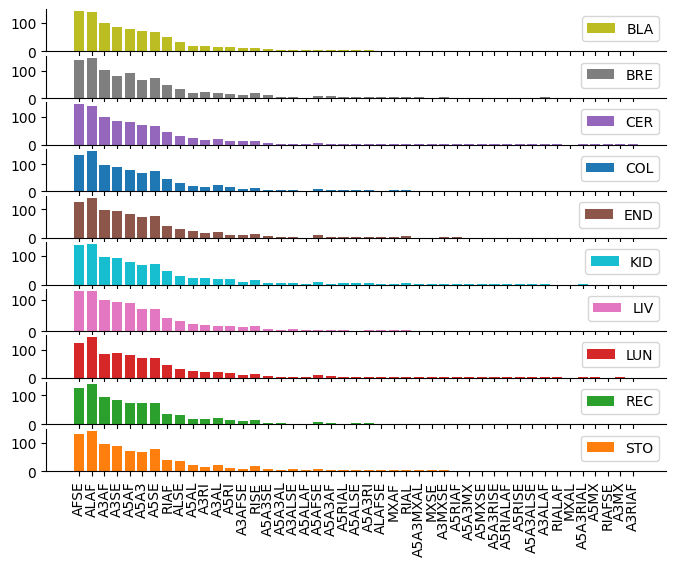

<Figure size 640x480 with 0 Axes>

In [221]:
fig, axs = plt.subplots(10, 1, figsize=(8,6), sharex=True, gridspec_kw={"hspace": 0.1})
for i in range(10):
    tissue = plot_data.columns.tolist()[i]
    axs[i].bar(all_tissue_pattern_data['pattern'].tolist(),all_tissue_pattern_data[tissue].tolist(), color = ten_colors[tissue], label=tissue)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].legend(loc='upper right')
    # axs[i].set_ylim(0,20)
plt.xticks(rotation=90)
plt.show()
plt.savefig('/data1/HOMO_PANGENOME/DYY/data/bambu/plot/1225subplot_bar_novel_trans_suppa_pattern.pdf',bbox_inches='tight')

# test

In [49]:
all_tissue_pattern_data.loc[:,'mean'] = all_tissue_pattern_data.sum(axis=1)/10
all_tissue_pattern_data = all_tissue_pattern_data.sort_values('mean',ascending=False).drop('mean', axis=1)

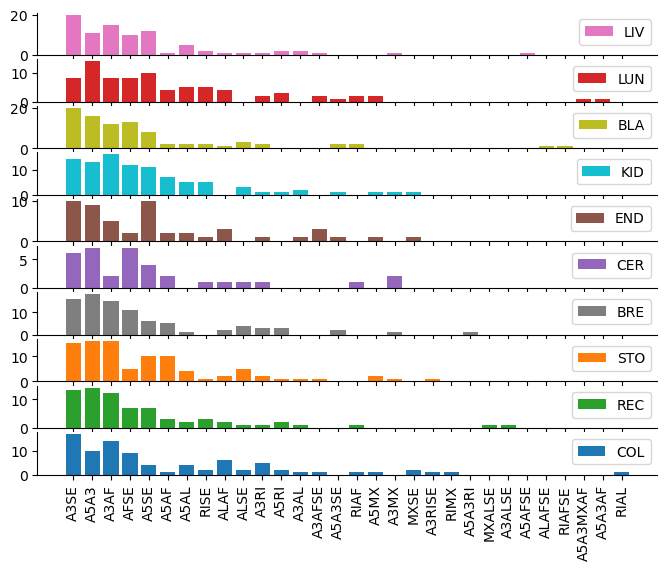

In [55]:
fig, axs = plt.subplots(10, 1, figsize=(8,6), sharex=True, gridspec_kw={"hspace": 0.1})
for i in range(10):
    tissue = trans_files[i][:3]
    axs[i].bar(all_tissue_pattern_data['pattern'].tolist(),all_tissue_pattern_data[tissue].tolist(), color = colors[tissue], label=tissue)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].legend(loc='upper right')
plt.xticks(rotation=90)
# plt.show()
plt.savefig('/data1/HOMO_PANGENOME/DYY/plot/1212subplot_bar_novel_trans_suppa_pattern.pdf',bbox_inches='tight')

normal组织中有表达的但不是normal primary的transcript发生的结构改变

In [ ]:
path = '/data1/HOMO_PANGENOME/DYY/data/8.1_suppa_by_tis/'
files = os.listdir(path)
files = [x for x in files if x[-3:]=='csv']
suppa_dict = {} #suppa types by tissues
for f in files:
    data = pd.read_csv(path+f,sep='\t')
    tpm_data = tpm_dict[f[:3]].loc[tpm_dict[f[:3]]['Type']=='Normal'].drop(['Type'],axis=1)
    mstrg_list = tpm_data.loc[:,tpm_data.sum()>0].columns.tolist()
    merge_data = data.loc[data.transcript.isin(mstrg_list)]
    normal_primary_list = normal_primary_data.loc[normal_primary_data[f[:3]]==1].transcript.tolist()
    suppa_dict[f[:3]] = merge_data.loc[~merge_data.transcript.isin(normal_primary_list)]
    # break

AttributeError: 'DataFrame' object has no attribute 'transcript'

In [78]:
merge_data

,transcript,A5,A3,RI,MX,AL,AF,SE
1,MSTRG.100020.1,NaN,NaN,NaN,NaN,NaN,1.0,1.0
5,MSTRG.100020.2,NaN,NaN,NaN,NaN,NaN,NaN,1.0
9,MSTRG.100020.6,NaN,1.0,NaN,NaN,NaN,NaN,1.0
10,MSTRG.100020.7,NaN,NaN,NaN,NaN,NaN,NaN,1.0
11,MSTRG.100020.8,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
146597,MSTRG.99972.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146600,MSTRG.99982.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146601,MSTRG.99983.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146602,MSTRG.99984.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
tissues=[x[:3] for x in files]

In [58]:
for key,value in suppa_dict.items():
    value.fillna(0).to_csv(f'/data1/HOMO_PANGENOME/DYY/data/9.26_upset_data_other_transcripts_suppa_type/{key}.csv',sep='\t',index=False)

In [80]:
intersect_path = '/data1/HOMO_PANGENOME/DYY/data/9.26_venn_intersect_data/'
intersect_files = os.listdir(intersect_path)
intersect_files = [x for x in intersect_files if x[-3:]=='csv']
intersect_dict={}
for i in intersect_files:
    intersect_data = pd.read_csv(intersect_path+i, sep='\t')
    intersect_data.columns=['A5','A3','RI','MX','AL','AF','SE','count','transcript']
    intersect_dict[i[:3]] = intersect_data
    # break

In [81]:
calculate_dict={}
for f in files:
    calculate_data = intersect_dict[f[:3]]
    calculate_data = calculate_data.sort_values('count', ascending=False)
    calculate_data = calculate_data[calculate_data['count']>0]
    for o in calculate_data.columns[:7]:
        calculate_data.loc[calculate_data[o]==True,o] = o
        calculate_data.loc[calculate_data[o]==False,o] = ''
    calculate_data['pattern'] = calculate_data.iloc[:,:7].apply(lambda x: ''.join(x),axis=1)
    calculate_dict[f[:3]] = calculate_data.loc[:,['pattern','count']]

In [82]:
merge_non_cancer_calculate = pd.DataFrame()
for f in files:
    name = f[:3]
    calculate_df = calculate_dict[name].rename(columns={'count':name})
    try:
        merge_non_cancer_calculate = pd.merge(merge_non_cancer_calculate,calculate_df,on='pattern',how='outer')
    except:
        merge_non_cancer_calculate = calculate_df.copy()
    # break

tumor specific transcripts 统计

In [83]:
ts_intersect_path = '/data1/HOMO_PANGENOME/DYY/data/9.26_venn_intersect_ts_data/'
ts_intersect_dict={}
for i in intersect_files:
    ts_intersect_data = pd.read_csv(ts_intersect_path+i, sep='\t')
    ts_intersect_data.columns=['A5','A3','RI','MX','AL','AF','SE','count','transcript']
    ts_intersect_dict[i[:3]] = ts_intersect_data
ts_calculate_dict={}
for f in files:
    ts_calculate_data = ts_intersect_dict[f[:3]]
    ts_calculate_data = ts_calculate_data.sort_values('count', ascending=False)
    ts_calculate_data = ts_calculate_data[ts_calculate_data['count']>0]
    for o in ts_calculate_data.columns[:7]:
        ts_calculate_data.loc[ts_calculate_data[o]==True,o] = o
        ts_calculate_data.loc[ts_calculate_data[o]==False,o] = ''
    ts_calculate_data['pattern'] = ts_calculate_data.iloc[:,:7].apply(lambda x: ''.join(x),axis=1)
    ts_calculate_dict[f[:3]] = ts_calculate_data.loc[:,['pattern','count']]
ts_merge_calculate = pd.DataFrame()
for f in files:
    name = f[:3]
    ts_calculate_df = ts_calculate_dict[name].rename(columns={'count':name})
    try:
        ts_merge_calculate = pd.merge(ts_merge_calculate,ts_calculate_df,on='pattern',how='outer')
    except:
        ts_merge_calculate = ts_calculate_df.copy()

In [85]:
ts_merge_calculate

,pattern,LIV,LUN,BLA,KID,END,CER,BRE,STO,REC,COL
0,SE,11.0,5.0,12.0,24.0,7.0,16.0,46.0,19.0,19.0,105.0
1,A3,10.0,10.0,16.0,18.0,5.0,8.0,44.0,11.0,25.0,133.0
2,AF,5.0,2.0,11.0,8.0,3.0,3.0,27.0,10.0,17.0,68.0
3,A5,5.0,7.0,11.0,14.0,10.0,9.0,35.0,21.0,21.0,106.0
4,A5AL,2.0,2.0,2.0,1.0,NaN,1.0,NaN,2.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
58,A3MXAFSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
59,A3MXAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
60,A5RIAFSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
61,RIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [84]:
import scipy.stats as stats

def proportion_test(p1, p2, n1, n2, side='two-sided'):
    """
    参数：
    p1: 样本1的比例
    p2: 样本2的比例
    n1: 样本1的数量
    n2: 样本2的数量
    side: 假设检验的方向，可选'two-sided'（双侧检验，默认）, 'greater'（右侧检验）, 'less'（左侧检验）

    返回值：
    z_value: Z统计量的值
    p_value: 对应的p值
    """
    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    se = np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))
    z_value = (p1 - p2) / se

    if side == 'two-sided':
        p_value = 2 * (1 - stats.norm.cdf(np.abs(z_value)))
    elif side == 'greater':
        p_value = 1 - stats.norm.cdf(z_value)
    elif side == 'less':
        p_value = stats.norm.cdf(z_value)
    else:
        raise ValueError("Invalid side value. Must be 'two-sided', 'greater', or 'less'.")

    return z_value, p_value

In [88]:
ts_only_pattern = ['A5A3MXAFSE', 'A5RIALAF', 'RIALAF']
normal_only_pattern = ['A3ALAFSE',
 'A3MXAL',
 'A3RIALAFSE',
 'A3RIMX',
 'A3RIMXAFSE',
 'A3RIMXSE',
 'A5A3ALAF',
 'A5A3MX',
 'A5A3MXAF',
 'A5A3RIAL',
 'A5ALAF',
 'A5MXAF',
 'A5RIALSE',
 'A5RIMX',
 'A5RIMXAF',
 'ALAFSE',
 'MXAFSE',
 'MXAL',
 'MXALSE',
 'RIALSE',
 'RIMXAF',
 'RIMXAFSE']

In [86]:
transcript_counts=pd.DataFrame(index=tissues)
for t in tissues:
    transcript_list=[]
    for m in ts_intersect_dict[t].transcript.dropna().tolist():
        try:
            transcript_list = transcript_list + [x for x in m.split(', ')]
        except:
            transcript_list.append(m)
    transcript_counts.loc[t,'counts'] = len(set(transcript_list))
# transcript_list.append(x) for x in m.split(', ')

将没有交集的pattern过滤掉，统计transcript总数时用全部transcript（样本量差距过大会有影响么？）

In [89]:
###过滤后的df
filter_non_cancer_calculate = merge_non_cancer_calculate[~merge_non_cancer_calculate.pattern.isin(normal_only_pattern)].set_index('pattern')
filter_ts_calculate = ts_merge_calculate[~ts_merge_calculate.pattern.isin(ts_only_pattern)].set_index('pattern')

In [90]:
patterns = filter_non_cancer_calculate.index.tolist()

In [91]:
###总数df
total_ts_counts = pd.DataFrame(ts_merge_calculate.sum(numeric_only=True),columns=['sums'])
total_nc_counts = pd.DataFrame(merge_non_cancer_calculate.sum(numeric_only=True),columns=['sums'])

In [92]:
multi_patterns = filter_non_cancer_calculate.loc[[x for x in filter_non_cancer_calculate.index if len(x)>2]].index.tolist()

In [93]:
most_nc_pattern_list = []
most_ts_pattern_list = []
for t in tissues:
    most_nc_pattern_list = most_nc_pattern_list + [x for x in filter_non_cancer_calculate.loc[[x for x in filter_non_cancer_calculate.index if len(x)>2]].sort_values(t, ascending=False).index[0:4].tolist()]
    most_ts_pattern_list = most_ts_pattern_list + [x for x in filter_ts_calculate.loc[[x for x in filter_ts_calculate.index if len(x)>2]].sort_values(t, ascending=False).head().index[0:4].tolist()]
    # break

In [94]:
set(most_ts_pattern_list)-set(most_nc_pattern_list)

{'A3AF', 'A3AL', 'A5A3AF', 'A5A3SE', 'A5AF', 'A5AFSE', 'A5AL'}

In [95]:
set(most_nc_pattern_list)

{'A3SE', 'A5A3', 'A5SE', 'AFSE'}

In [96]:
from  scipy.stats import chi2_contingency

In [97]:
from scipy.stats import fisher_exact

In [98]:
p_value_df = pd.DataFrame(index=tissues, columns=patterns)
for u in tissues:
    c_n = total_nc_counts.loc[u,'sums']
    c_t = total_ts_counts.loc[u,'sums']
    for p in patterns:
        n = filter_non_cancer_calculate.loc[p, u]
        t = filter_ts_calculate.loc[p,u]
        if n*t>0:
            try:
                p_value = chi2_contingency([[n,c_n-n],[t,c_t-t]])[1]
            except:
                p_value = 1
        else:
            p_value = 1
        p_value_df.loc[u, p] = p_value

In [99]:
filter_non_cancer_calculate

,LIV,LUN,BLA,KID,END,CER,BRE,STO,REC,COL
pattern,,,,,,,,,,
SE,4376.0,5239.0,5503.0,5373.0,4728.0,3926.0,5827.0,5217.0,4333.0,5572.0
A3,1973.0,2231.0,2475.0,2376.0,2094.0,1792.0,2554.0,2182.0,1778.0,2397.0
A5,1826.0,2116.0,2272.0,2197.0,1914.0,1665.0,2206.0,2054.0,1731.0,2152.0
AF,1015.0,1204.0,1364.0,1331.0,1184.0,955.0,1374.0,1215.0,1072.0,1285.0
A3SE,920.0,1244.0,1268.0,1224.0,975.0,762.0,1271.0,1144.0,910.0,1286.0
A5SE,609.0,777.0,789.0,740.0,632.0,544.0,842.0,745.0,574.0,772.0
RI,432.0,547.0,683.0,583.0,525.0,442.0,606.0,532.0,446.0,628.0
AL,399.0,419.0,508.0,529.0,442.0,374.0,487.0,438.0,404.0,471.0
A5A3,281.0,312.0,345.0,330.0,263.0,227.0,364.0,306.0,246.0,311.0


In [25]:
fisher_p_value_df = pd.DataFrame(index=tissues, columns=patterns)
for u in tissues:
    c_n = total_nc_counts.loc[u,'sums']
    c_t = total_ts_counts.loc[u,'sums']
    for p in patterns:
        n = filter_non_cancer_calculate.loc[p, u]
        t = filter_ts_calculate.loc[p,u]
        n1 = c_n*(n+t)/(c_n+c_t)
        t1 = c_t*(n+t)/(c_n+c_t)
        if n*t>0:
            if (n1>5) & (t1>5):
                try:
                    p_value = chi2_contingency([[n,c_n-n],[t,c_t-t]])[1]
                except:
                    p_value = 1
            else:
                p_value = fisher_exact([[n,c_n-n],[t,c_t-t]],alternative='greater')[1]
        else:
            p_value = 1
        fisher_p_value_df.loc[u, p] = p_value

In [26]:
sig_df = pd.DataFrame()
for p in patterns:
    significant_tissue = p_value_df.loc[p_value_df.loc[:,p]<0.05,p].index.tolist()
    if len(significant_tissue)>0:
        sig_df.loc[p,'tissues'] = significant_tissue

ValueError: Must have equal len keys and value when setting with an iterable

In [27]:
from statsmodels.stats.multitest import multipletests

In [28]:
p_value_df

,SE,A3,A5,AF,A3SE,A5SE,RI,AL,A5A3,AFSE,...,RIMX,A3RIAL,A3MXAFSE,A5RIAF,A5MXAFSE,A5A3RIAFSE,A5RIMXSE,A5RIAL,A5A3RIAF,A5A3RIMXSE
LIV,0.247099,0.277371,0.717445,0.593067,0.325729,0.66497,0.999462,1,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
LUN,0.00005,0.804255,0.750963,0.283112,0.784533,0.359515,0.107338,0.508353,0.000121,0.337219,...,1,1,1,1,1,1,1,1,1,1
BLA,0.000133,0.539565,0.805875,0.235731,0.804261,0.702984,0.916729,1.0,0.231708,0.270312,...,1,1,1,1,1,1,1,1,1,1
KID,0.004151,0.982937,0.670295,0.677281,0.855893,0.026964,0.173135,0.405936,0.180438,1.0,...,1,1,1,1,1,1,1,1,1,1
END,0.046259,0.826472,0.066597,1.0,0.42396,1,1,0.834356,0.388174,0.479556,...,1,1,1,0.0,1,1,1,1,0.0,1
CER,0.702556,1.0,0.714767,0.67661,0.277159,0.985992,1,0.163027,0.015036,1,...,0.0,1,1,1,1,1,1,1,1,1
BRE,0.0,0.772509,0.922577,0.380447,0.871598,1.0,0.274536,0.604002,0.0,0.62245,...,1,0.244316,1,1,1,1,0.008541,1,1,0.008541
STO,0.0,0.026626,0.854553,0.723409,0.639229,0.373758,0.535941,0.261832,0.001258,1.0,...,1,0.017337,1,1,1,1,1,1,0.000459,1
REC,0.0,0.398728,0.969415,0.254735,0.000016,0.203704,0.442703,1.0,0.001075,0.761772,...,1,1,1,1,1,1,1,1,1,1
COL,0.0,0.071777,0.758366,0.41619,0.232489,0.438979,0.242662,0.84903,0.0,1.0,...,0.000157,1,1,0.000157,1,1,1,0.000157,1,1


In [495]:
multipletests(p_value_df, method='fdr_bh')

AssertionError: pvals must be 1-dimensional, that is of shape (n,)

In [494]:
p_value_df.apply(lambda x:multipletests(x, method='fdr_bh'))

,SE,A3,A5,AF,A3SE,A5SE,RI,AL,A5A3,AFSE,...,RIMX,A3RIAL,A3MXAFSE,A5RIAF,A5MXAFSE,A5A3RIAFSE,A5RIMXSE,A5RIAL,A5A3RIAF,A5A3RIMXSE
0,"[False, True, True, True, False, False, True, ...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, True, False, False, False, True, True,...","[False, False, False, False, False, False, Fal...",...,"[False, False, False, False, False, True, Fals...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, True, False, Fals...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[False, False, False, False, True, False, Fals...","[False, False, False, False, False, False, Fal..."
1,"[0.2745540888801764, 0.00010007543719433154, 0...","[0.9245702377232417, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9694152838649333, 0.9694152838649333, 0.969...","[0.8037877483878711, 0.8037877483878711, 0.803...","[0.8143214531539528, 0.8715975965928497, 0.871...","[1.0, 0.877957716498853, 1.0, 0.26963795839985...","[1.0, 0.6863411584571891, 1.0, 0.6863411584571...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 0.0004043240686280462, 0.289635136133136...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[1.0, 1.0, 1.0, 1.0, 1.0, 2.2772060544189985e-...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.17336785...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.057531341848627e-06, 1....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0854119605058...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 5.790560213462785e-10, 1....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0854119605058..."
2,0.005116,0.005116,0.005116,0.005116,0.005116,0.005116,0.005116,0.005116,0.005116,0.005116,...,0.005116,0.005116,0.005116,0.005116,0.005116,0.005116,0.005116,0.005116,0.005116,0.005116
3,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,...,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005


In [428]:
sig_df.loc[sig_df.index.isin(set(most_ts_pattern_list)-set(most_nc_pattern_list))]

,tissues
A5A3SE,"[BRE, COL]"
A3AF,"[BRE, REC, COL]"
A5AF,"[BLA, KID, BRE, STO, REC, COL]"
A5AFSE,"[LIV, LUN, END, CER, BRE, STO, REC, COL]"
A5AL,"[LIV, LUN, BLA, KID, CER, STO, REC, COL]"
A3AL,"[LIV, KID, REC, COL]"
A5A3AF,"[LIV, KID, END, BRE, REC, COL]"


In [492]:
sig_df.loc[sig_df.index.isin(set(most_ts_pattern_list)-set(most_nc_pattern_list))]

,tissues
A5A3SE,"[BRE, COL]"
A3AF,"[BRE, REC, COL]"
A5AF,"[BLA, KID, BRE, STO, REC, COL]"
A5AFSE,"[LIV, LUN, END, CER, BRE, STO, REC, COL]"
A5AL,"[LIV, LUN, BLA, KID, CER, STO, REC, COL]"
A3AL,"[LIV, KID, REC, COL]"
A5A3AF,"[LIV, KID, END, BRE, REC, COL]"


In [437]:
filter_non_cancer_calculate.loc['A5AFSE']

LIV    31.0
LUN    50.0
BLA    53.0
KID    53.0
END    40.0
CER    34.0
BRE    53.0
STO    48.0
REC    41.0
COL    47.0
Name: A5AFSE, dtype: float64

In [438]:
filter_ts_calculate.loc['A5AFSE']

LIV    1.0
LUN    1.0
BLA    NaN
KID    NaN
END    1.0
CER    2.0
BRE    5.0
STO    1.0
REC    1.0
COL    4.0
Name: A5AFSE, dtype: float64

In [345]:
chi2_contingency([[1244,16201-1244],[6,64-6]])[1]

0.7845330264407413